In [16]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [18]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [19]:
features = np.load("train_features_axial.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("train_labels_axial.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("train_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(169650, 512)
(169650,)
(169650,)


In [20]:
features = np.load("val_features_axial.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("val_labels_axial.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("val_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(8415, 512)
(8415,)
(8415,)


In [ ]:
# Load Training Set
X = np.load("train_fused_features_clean.npy")
y = np.load("train_fused_labels_clean.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("train_fused_embeddings_with_labels.csv", index=False)
print(" Saved: train_fused_embeddings_with_labels.csv")

print(" Saved:")
print("  train_fused_features_clean.npy (shape:", X.shape, ")")
print("  train_fused_labels_clean.npy  (shape:", y.shape, ")")

# Load Validation Set
X = np.load("val_fused_features_clean.npy")
y = np.load("val_fused_labels_clean.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("val_fused_embeddings_with_labels.csv", index=False)
print(" Saved: val_fused_embeddings_with_labels.csv")

print(" Saved:")
print("  val_fused_features_clean.npy (shape:", X.shape, ")")
print("  val_fused_labels_clean.npy  (shape:", y.shape, ")")

 Saved: train_fused_embeddings_with_labels.csv
 Saved:
  train_fused_features_clean.npy (shape: (169650, 1024) )
  train_fused_labels_clean.npy  (shape: (169650,) )
 Saved: val_fused_embeddings_with_labels.csv
 Saved:
  val_fused_features_clean.npy (shape: (8415, 1024) )
  val_fused_labels_clean.npy  (shape: (8415,) )


In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

X_train = np.load("train_fused_features_clean.npy")
y_train = np.load("train_fused_labels_clean.npy")
X_val = np.load("val_fused_features_clean.npy")

# Select top 150 features
selector = SelectKBest(score_func=f_classif, k=150)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

# Save
np.save("train_fused_kBestSelected.npy", X_train_selected)
np.save("val_fused_kBestSelected.npy", X_val_selected)

# Optional: Get indices of selected features
selected_indices = selector.get_support(indices=True)
print("Selected feature indices:", selected_indices)

Selected feature indices: [  56  516  529  537  540  542  543  544  546  550  554  556  562  567
  569  570  580  581  582  583  586  588  594  596  601  602  603  607
  609  612  614  616  617  619  620  621  623  627  628  629  634  635
  637  644  646  647  654  658  659  660  664  665  671  673  678  680
  683  688  690  691  692  696  699  709  713  719  721  729  731  738
  747  748  750  751  759  761  766  769  770  771  778  781  782  783
  792  794  795  797  799  804  813  834  837  842  844  845  850  852
  854  856  858  863  869  872  873  875  876  877  880  887  891  893
  895  901  902  910  912  913  919  921  926  928  936  937  941  942
  944  945  949  958  960  965  969  974  977  979  980  981  992  994
  996  998  999 1003 1004 1005 1006 1007 1010 1023]


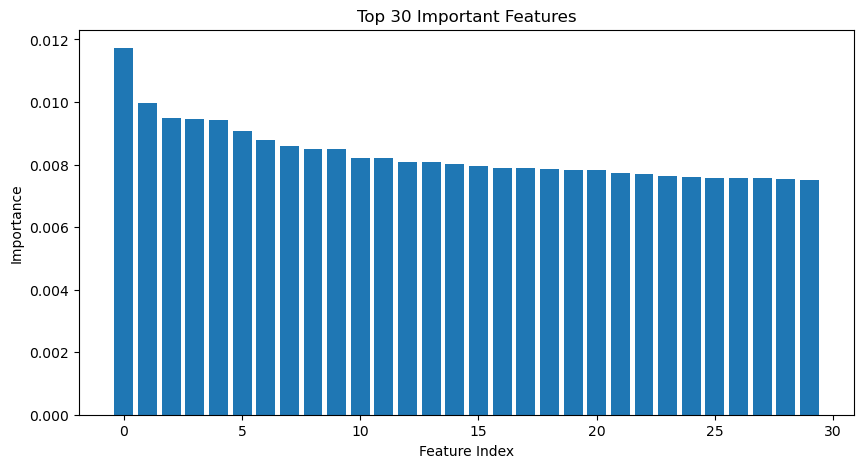

In [7]:
import numpy as np
import joblib

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

# Visualize top 30
indices = np.argsort(importances)[::-1][:30]
top_indices = np.argsort(importances)[::-1][:30]
X_train_reduced = X_train[:, top_indices]
X_val_reduced = X_val[:, top_indices]  # Do the same for test/val sets

# Save reduced datasets
np.save("X_train_reduced.npy", X_train_reduced)
np.save("X_val_reduced.npy", X_val_reduced)

# Save selected feature indices for future use
joblib.dump(top_indices, "selected_rf_indices.pkl")
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_val[:, top_indices]  # Do the same for test/val sets
plt.figure(figsize=(10, 5))
plt.bar(range(len(indices)), importances[indices])
plt.title("Top 30 Important Features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

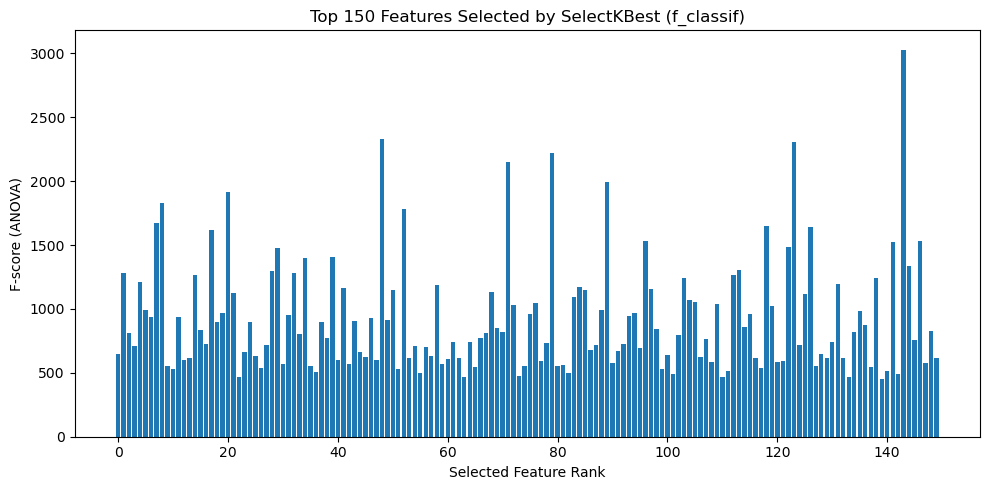

In [13]:
import matplotlib.pyplot as plt

# Access the F-scores
f_scores = selector.scores_

# Get scores of only selected features
selected_scores = f_scores[selected_indices]

# Plot top 150 selected feature scores
plt.figure(figsize=(10, 5))
plt.bar(range(len(selected_scores)), selected_scores)
plt.title("Top 150 Features Selected by SelectKBest (f_classif)")
plt.xlabel("Selected Feature Rank")
plt.ylabel("F-score (ANOVA)")
plt.tight_layout()
plt.show()

In [28]:
! pip install matplotlib_venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 749.0 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45388 sha256=b257dd38e2ec44f32ab855ddd3bc43101693f0fb932440ebb59b389b84fa7392
  Stored in directory: /Users/fatimatuzzahra/Library/Caches/pip/wheels/c2/47/0c/f014c55a1cfd56dce41a1cafd23e3c590652b5e71330cc181c
Successfully built matplotlib_venn


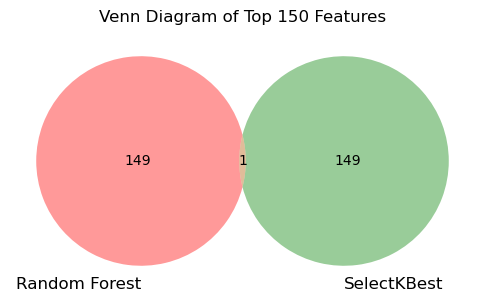

In [31]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Sets of selected feature indices
rf_indices = np.argsort(rf.feature_importances_)[::-1][:150]
rf_set = set(rf_indices)
kbest_set = set(selected_indices)

# Plot the Venn diagram
plt.figure(figsize=(6, 5))
venn2([rf_set, kbest_set], set_labels=("Random Forest", "SelectKBest"))
plt.title("Venn Diagram of Top 150 Features")
plt.show()

In [2]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Example usage:
input_dim = X_train.shape[1]
model = MLPWithDropout(input_dim).to(device)

In [3]:
# run this for no randomness
import torch
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional for PyTorch >=1.8
    torch.use_deterministic_algorithms(True)

Using device: cpu
Epoch 1/100, Train Loss: 0.6813, Val Loss: 0.6869
Epoch 2/100, Train Loss: 0.6665, Val Loss: 0.6873
Epoch 3/100, Train Loss: 0.6580, Val Loss: 0.6870
Epoch 4/100, Train Loss: 0.6497, Val Loss: 0.6864
Epoch 5/100, Train Loss: 0.6413, Val Loss: 0.6864
Epoch 6/100, Train Loss: 0.6331, Val Loss: 0.6863
Epoch 7/100, Train Loss: 0.6246, Val Loss: 0.6861
Epoch 8/100, Train Loss: 0.6174, Val Loss: 0.6865
Epoch 9/100, Train Loss: 0.6105, Val Loss: 0.6872
Epoch 10/100, Train Loss: 0.6028, Val Loss: 0.6867
Epoch 11/100, Train Loss: 0.5969, Val Loss: 0.6847
Epoch 12/100, Train Loss: 0.5898, Val Loss: 0.6848
Epoch 13/100, Train Loss: 0.5834, Val Loss: 0.6855
Epoch 14/100, Train Loss: 0.5768, Val Loss: 0.6840
Epoch 15/100, Train Loss: 0.5700, Val Loss: 0.6853
Epoch 16/100, Train Loss: 0.5650, Val Loss: 0.6851
Epoch 17/100, Train Loss: 0.5598, Val Loss: 0.6856
Epoch 18/100, Train Loss: 0.5525, Val Loss: 0.6857
Epoch 19/100, Train Loss: 0.5463, Val Loss: 0.6872
⏹ Early stopping trigg

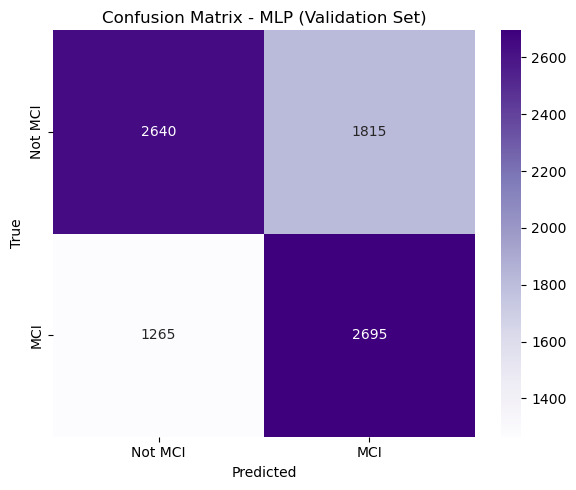

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("X_train_reduced.npy")
y_train = np.load("train_fused_labels_clean.npy")
X_val = np.load("X_val_reduced.npy")
y_val = np.load("val_fused_labels_clean.npy")

y_train = np.where(y_train == 2, 1, 0)
y_val = np.where(y_val == 2, 1, 0)

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # False for no randomess in mini-batches
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)



input_dim = X_train.shape[1]  # or manually set to 256 for image-only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = MLPWithDropout(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Early stop[ping variables
num_epochs = 100
patience = 5  # how many epochs to wait before early stopping

train_losses = []
val_losses = []

best_val_loss = float("inf")
early_stop_epoch = -1
epochs_no_improve = 0
best_model_state = None



for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------------- Validation and Early Stopping ----------------
    model.eval()
    val_loss = 0.0
    y_val_preds = []
    y_val_true = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.unsqueeze(1).float())
            val_loss += loss.item()
            preds = (torch.sigmoid(out).squeeze() > 0.5).int()
            y_val_preds.extend(preds.cpu().numpy())
            y_val_true.extend(yb.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        early_stop_epoch = epoch
        best_model_state = model.state_dict()

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop_epoch = epoch  # ⏹️ Where stopping actually happens
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break
# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = (torch.sigmoid(out).squeeze() > 0.5).int()  
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

    # Training Metrics
    train_acc = accuracy_score(y_train_true, y_train_preds)
    print(f" Training Accuracy: {train_acc:.4f}")

# Restore best model
model.load_state_dict(best_model_state)

# Final evaluation on validation set
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f" Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["Not MCI", "MCI"]))

cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Not MCI", "MCI"], yticklabels=["Not MCI", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

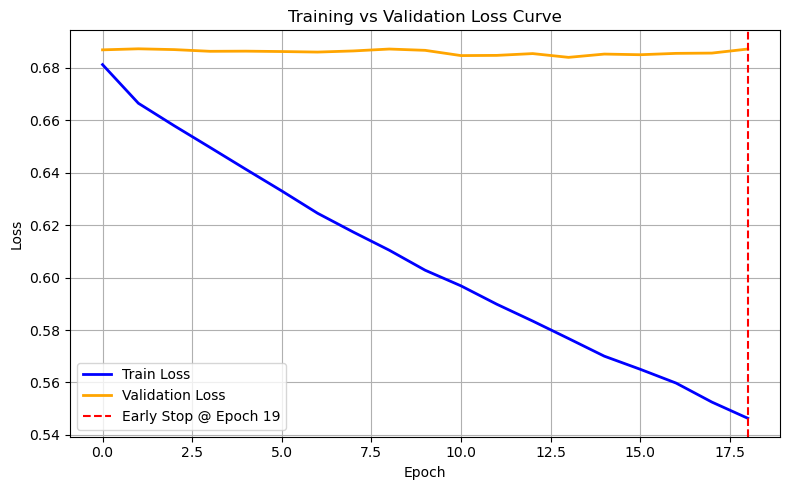

In [10]:
# Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

# Mark early stopping epoch
if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()